# Imports

In [1]:
import ee
import numpy as np
import math
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#ee.Authenticate()


In [3]:

# Initialize Google Earth Engine
ee.Initialize()

In [4]:
nm_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\climate\NM\nm_vector.gpkg"
study_boundary = gpd.read_file(nm_path, layer='counties_dissolved')
hurley_gdf = gpd.read_file(nm_path, layer='hurley')

In [5]:
# Convert to Earth Engine geometry
ee_boundary = geemap.geopandas_to_ee(study_boundary)

ee_hurley = geemap.geopandas_to_ee(hurley_gdf).geometry()


In [6]:
ee_boundary_coordinates = ee_boundary.geometry()

# Landsat Collection 2

In [7]:
# Function to scale the surface temperature band and convert to Fahrenheit
def scale_lst(image):
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_f = lst_k.subtract(273.15).multiply(1.8).add(32)
    return image.addBands(lst_f.rename('LST_F'))

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
    return image.addBands(ndvi.rename('NDVI'))

# Function to calculate Fraction of Vegetation Cover
def calculate_fvc(image):
    fvc = image.select('NDVI').subtract(0.2).divide(0.3).pow(2).clamp(0, 1)
    return image.addBands(fvc.rename('FVC'))

# Function to calculate Emissivity
def calculate_emissivity(image):
    emissivity = image.select('FVC').multiply(0.0004).add(0.986)
    return image.addBands(emissivity.rename('Emissivity'))

# Define a function to clip each image to the ROI
def clip_to_region(image,roi):
    return image.clip(roi)


In [8]:
pt = ee.Geometry.Point([-108.13, 32.70])   # Point corresponding to Santa Barbara, CA


# Load the Landsat 8 collection and filter images based on criteria
landsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-04-01', '2019-09-18') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover
# Load the Landsat 8 collection and filter images based on criteria
landsat_collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-09-19', '2024-08-14') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover

# Load the Landsat 8 collection and filter images based on criteria
landsat_collection3 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate( '2024-08-15', '2024-11-01') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover


In [9]:
# Combine the collections
combined_collection = landsat_collection1.merge(landsat_collection2).merge(landsat_collection3)


In [10]:
combined_collection

In [11]:
# Get the list of image dates that meet the criteria
image_dates = combined_collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()

print("Selected Image Dates:")
print(image_dates)

Selected Image Dates:
['2019-05-29', '2019-06-30', '2019-08-01', '2019-09-02', '2020-05-15', '2020-05-31', '2020-06-16', '2020-08-03', '2020-08-19', '2020-09-04', '2020-09-20', '2021-05-02', '2021-06-03', '2021-06-19', '2021-07-21', '2021-08-06', '2021-08-22', '2021-09-07', '2022-05-05', '2022-05-21', '2022-06-06', '2022-07-08', '2022-09-10', '2023-05-08', '2023-05-24', '2023-06-25', '2023-07-27', '2023-09-29', '2024-05-10', '2024-05-26', '2024-06-11', '2024-07-13', '2024-08-30']


In [12]:
# Apply all processing steps
processed_collection = combined_collection \
    .map(lambda image: image.clip(ee_hurley)) \
    .map(scale_lst) \
    .map(calculate_ndvi) \
    .map(calculate_fvc) \
    .map(calculate_emissivity) 


In [13]:
processed_collection

In [14]:
# Function to extract LST values
def extract_lst(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_lst = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_hurley,
        scale=30
    ).get('LST_F')
    return ee.Feature(None, {'date': date, 'LST': mean_lst})

# Extract LST values
lst_values = processed_collection.map(extract_lst)


In [15]:
lst_values

In [17]:
# Print results
print("Date, Mean LST (°F)")
lst_list = lst_values.getInfo().get('features')
for feature in lst_list:
    date = feature['properties']['date']
    lst = feature['properties']['LST']
    print(f"{date}, {lst:.2f}")

# Print collection information
print(f"\nNumber of images: {processed_collection.size().getInfo()}")
print(f"Date range: {start_date} to {end_date}")

# Print cloud cover information
cloud_covers = processed_collection.aggregate_array('CLOUD_COVER').getInfo()
dates = processed_collection.aggregate_array('system:time_start').getInfo()
dates = [ee.Date(d).format('YYYY-MM-dd').getInfo() for d in dates]

print("\nCloud cover for each image:")
for date, cloud_cover in zip(dates, cloud_covers):
    print(f"{date}: {cloud_cover:.2f}%")

Date, Mean LST (°F)
2019-05-29, 113.70
2019-06-30, 120.15
2019-08-01, 116.24
2019-09-02, 118.19
2020-05-15, 114.31
2020-05-31, 118.78
2020-06-16, 121.98
2020-08-03, 131.92
2020-08-19, 124.42
2020-09-04, 121.08
2020-09-20, 110.28
2021-05-02, 106.01
2021-06-03, 125.47
2021-06-19, 137.86
2021-07-21, 130.94
2021-08-06, 103.89
2021-08-22, 111.57
2021-09-07, 109.55
2022-05-05, 113.88
2022-05-21, 120.25
2022-06-06, 127.24
2022-07-08, 125.05
2022-09-10, 114.17
2023-05-08, 117.38
2023-05-24, 116.53
2023-06-25, 128.33
2023-07-27, 136.58
2023-09-29, 108.92
2024-05-10, 109.43
2024-05-26, 116.20
2024-06-11, 129.88
2024-07-13, 122.77
2024-08-30, 111.96

Number of images: 33


NameError: name 'start_date' is not defined

In [ ]:
""" ## Define the specific dates you want to inspect
specific_dates = ['2019-09-18', '2024-08-14']  # Replace with your desired dates

# Filter the collection for specific dates using ee.Filter.Or
filtered_collection = processed_collection.filter(
    ee.Filter.Or(
        ee.Filter.date(specific_dates[0], ee.Date(specific_dates[0]).advance(1, 'day')),
        ee.Filter.date(specific_dates[1], ee.Date(specific_dates[1]).advance(1, 'day'))
    )
)

# Check if the collection is empty
if filtered_collection.size().getInfo() == 0:
    raise ValueError("No images found for the specified dates.")

# Create the map and add true-color layers for the specific dates
Map = geemap.Map()
Map.center_object(ee_hurley, 12)

# Visualization parameters for true-color composite
true_color_vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,  # Adjust based on the reflectance range of your data
    'gamma': 1.4  # Optional: adjust for better visualization
}

# Add true-color layers for each date
filtered_images = filtered_collection.toList(filtered_collection.size())
for i in range(filtered_collection.size().getInfo()):
    image = ee.Image(filtered_images.get(i))
    image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    Map.addLayer(image, true_color_vis_params, f'True Color {image_date}')

Map.addLayer(ee_hurley, {}, 'Hurley Boundary')
Map """




In [18]:
# Calculate the mean image across the entire collection
collection_mean = processed_collection.mean()

# Extract the mean LST over the Hurley area
mean_lst = collection_mean.select('LST_F').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_hurley,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).get('LST_F')

# Get the result as a Python object
mean_lst_value = mean_lst.getInfo()

print("Mean LST (°F) for the entire collection over Hurley, NM:", mean_lst_value)


Mean LST (°F) for the entire collection over Hurley, NM: 119.23347972114891


In [19]:
# Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=collection_mean.select('LST_F'),  # Select the LST band
    description='Hurley_LST_Mean',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='Hurley_LST_Mean_Image',
    region=ee_hurley,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the Hurley vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting mean LST image to Google Drive...")

Exporting mean LST image to Google Drive...


In [20]:
Map = geemap.Map()
Map.center_object(ee_hurley, 12)
Map.addLayer(collection_mean, {}, 'collection_mean')
Map


Map(center=[32.70342976932359, -108.12776175752273], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
# Function to calculate per-image statistics for LST
def calculate_stats_per_image(image):
    stats = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=ee_hurley,
        scale=30,
        maxPixels=1e8,
        bestEffort=True
    )
    return image.set(stats)

In [22]:
# Apply the function to each image in the collection to get per-image statistics
stats_per_image = processed_collection.map(calculate_stats_per_image)

In [23]:
stats_per_image

In [24]:
# Extract individual statistics
dates = stats_per_image.aggregate_array('system:time_start').getInfo()
means = stats_per_image.aggregate_array('LST_F_mean').getInfo()
mins = stats_per_image.aggregate_array('LST_F_min').getInfo()
maxs = stats_per_image.aggregate_array('LST_F_max').getInfo()
std_devs = stats_per_image.aggregate_array('LST_F_stdDev').getInfo()


In [25]:
# Print per-image statistics
print("Per-image LST statistics:")
for date, mean, min_, max_, std_dev in zip(dates, means, mins, maxs, std_devs):
    formatted_date = ee.Date(date).format("YYYY-MM-dd").getInfo()
    print(f"Date: {formatted_date}, Mean LST: {mean}, Min LST: {min_}, Max LST: {max_}, StdDev LST: {std_dev}")

Per-image LST statistics:
Date: 2019-05-29, Mean LST: 113.69681354601337, Min LST: 107.27383485200004, Max LST: 119.36337159200005, StdDev LST: 1.9665240790485665
Date: 2019-06-30, Mean LST: 120.15072108824377, Min LST: 110.57154054799996, Max LST: 125.42352105200007, StdDev LST: 2.5304108599134105
Date: 2019-08-01, Mean LST: 116.23895506078009, Min LST: 104.89899455600008, Max LST: 122.65492485200004, StdDev LST: 3.0263021256994556
Date: 2019-09-02, Mean LST: 118.19161153941705, Min LST: 106.0125854720001, Max LST: 124.40221667600005, StdDev LST: 2.9867809193784285
Date: 2020-05-15, Mean LST: 114.30800541660562, Min LST: 107.01543254000008, Max LST: 119.20956069200008, StdDev LST: 2.089222392051503
Date: 2020-05-31, Mean LST: 118.77592754824022, Min LST: 112.44803352800005, Max LST: 122.62416267200011, StdDev LST: 1.8717334685565004
Date: 2020-06-16, Mean LST: 121.98277030740587, Min LST: 112.454185964, Max LST: 129.70561650800005, StdDev LST: 2.7382501745408208
Date: 2020-08-03, Mean

In [26]:
# Calculate overall statistics for the entire collection (min, max, stdDev)
collection_min = processed_collection.select('LST_F').reduce(ee.Reducer.min()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_hurley,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_max = processed_collection.select('LST_F').reduce(ee.Reducer.max()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_hurley,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_stddev = processed_collection.select('LST_F').reduce(ee.Reducer.stdDev()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_hurley,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

# Print overall statistics
print("\nOverall Collection Statistics:")
print(f"Min LST: {collection_min}")
print(f"Max LST: {collection_max}")
print(f"StdDev LST: {collection_stddev}")


Overall Collection Statistics:
Min LST: {'LST_F_min': 101.82676299613765}
Max LST: {'LST_F_max': 138.6642869032802}
StdDev LST: {'LST_F_stdDev': 8.711025156722}


Per-Image Standard Deviation: For each image, the standard deviation shows the variability of LST across the Hurley area at a specific time. A low standard deviation means the temperatures are relatively uniform across the region, while a high standard deviation suggests there are large differences in temperature within that image, perhaps due to mixed land covers or varying microclimates.

Overall Collection Standard Deviation: When calculated across the entire collection, the standard deviation reflects how much the mean LST changes over time. A low value indicates that the temperatures are fairly stable across the whole period, while a high standard deviation suggests significant temperature changes over time, such as seasonal variations or extreme weather events.

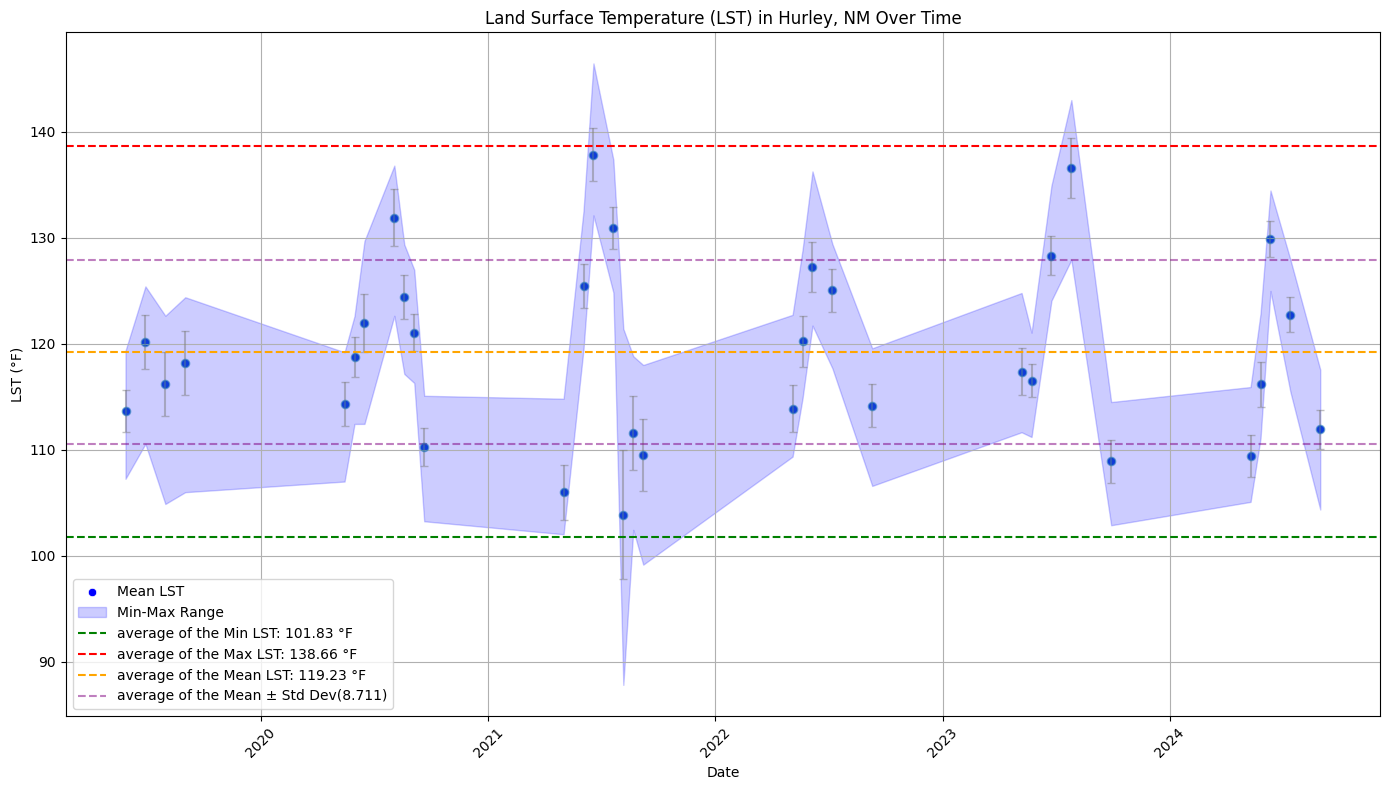

In [31]:
# Create the DataFrame
data = {
    'Date': [ee.Date(date).format("YYYY-MM-dd").getInfo() for date in dates],
    'Mean_LST': means,
    'Min_LST': mins,
    'Max_LST': maxs,
    'StdDev_LST': std_devs
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Overall collection statistics
overall_min = 101.83 
overall_max = 138.66  
overall_std_dev = 8.711
overall_mean =  119.23 

# Set up the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Date', y='Mean_LST', data=df, color='blue', label='Mean LST')

# Add error bars for standard deviation
plt.errorbar(df['Date'], df['Mean_LST'], yerr=df['StdDev_LST'], fmt='o', ecolor='gray', alpha=0.5, capsize=3)

# Add shaded area for Min-Max range
plt.fill_between(df['Date'], df['Min_LST'], df['Max_LST'], color='blue', alpha=0.2, label='Min-Max Range')

# Add overall statistics as horizontal lines
plt.axhline(overall_min, color='green', linestyle='--', label=f'average of the Min LST: {overall_min:.2f} °F')
plt.axhline(overall_max, color='red', linestyle='--', label=f'average of the Max LST: {overall_max:.2f} °F')
plt.axhline(overall_mean, color='orange', linestyle='--', label=f'average of the Mean LST: {overall_mean:.2f} °F')
plt.axhline(overall_mean + overall_std_dev, color='purple', linestyle='--', alpha=0.5, label=f'average of the Mean ± Std Dev({overall_std_dev})')
plt.axhline(overall_mean - overall_std_dev, color='purple', linestyle='--', alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('LST (°F)')
plt.title('Land Surface Temperature (LST) in Hurley, NM Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
""" # Compute the long-term baseline (mean of all images in the collection)
baseline = processed_collection.mean()

# Function to calculate the anomaly for each image
def calculate_anomaly(image):
    anomaly = image.select('LST_F').subtract(baseline.select('LST_F'))  # Subtract baseline pixel by pixel
    return image.addBands(anomaly.rename('LST_Anomaly'))  # Add anomaly as a new band

# Map the anomaly calculation across the processed collection
anomaly_collection = processed_collection.map(calculate_anomaly)

# Visualization parameters for anomalies
anomaly_vis_params = {
    'min': -20,  # Adjust based on expected range of anomalies
    'max': 20,
    'palette': ['blue', 'white', 'red'],  # Blue for cooler, red for warmer
}

# Add the mean anomaly layer to the map
Map = geemap.Map()
Map.center_object(ee_hurley, 12)

# Visualize mean anomaly across the collection
mean_anomaly = anomaly_collection.select('LST_Anomaly').mean()
Map.addLayer(mean_anomaly, anomaly_vis_params, 'Mean Temperature Anomaly')
Map.addLayer(ee_hurley, {}, 'Hurley Boundary')
Map
 """

" # Compute the long-term baseline (mean of all images in the collection)\nbaseline = processed_collection.mean()\n\n# Function to calculate the anomaly for each image\ndef calculate_anomaly(image):\n    anomaly = image.select('LST_F').subtract(baseline.select('LST_F'))  # Subtract baseline pixel by pixel\n    return image.addBands(anomaly.rename('LST_Anomaly'))  # Add anomaly as a new band\n\n# Map the anomaly calculation across the processed collection\nanomaly_collection = processed_collection.map(calculate_anomaly)\n\n# Visualization parameters for anomalies\nanomaly_vis_params = {\n    'min': -20,  # Adjust based on expected range of anomalies\n    'max': 20,\n    'palette': ['blue', 'white', 'red'],  # Blue for cooler, red for warmer\n}\n\n# Add the mean anomaly layer to the map\nMap = geemap.Map()\nMap.center_object(ee_hurley, 12)\n\n# Visualize mean anomaly across the collection\nmean_anomaly = anomaly_collection.select('LST_Anomaly').mean()\nMap.addLayer(mean_anomaly, anomaly_

In [29]:
""" # Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=mean_anomaly.select('LST_Anomaly'),  # Select the LST band
    description='Hurley_LST_Anomaly',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='Hurley_LST_Anomaly',
    region=ee_hurley,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the Hurley vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting LST_Anomaly to Google Drive...") """

' # Set up export parameters\nexport_task = ee.batch.Export.image.toDrive(\n    image=mean_anomaly.select(\'LST_Anomaly\'),  # Select the LST band\n    description=\'Hurley_LST_Anomaly\',\n    folder=\'lst\',  # Optional: specify a folder in Google Drive\n    fileNamePrefix=\'Hurley_LST_Anomaly\',\n    region=ee_hurley,\n    scale=30,\n    crs=\'EPSG:4326\',  # \'EPSG:32612\',  # Use UTM Zone 12N to match the Hurley vectors\n    maxPixels=1e13\n)\n\n# Start the export task\nexport_task.start()\nprint("Exporting LST_Anomaly to Google Drive...") '

Hurley Area

In [1]:
(1874540.995237139 + 385529.09372809314)

2260070.088965232

In [3]:
2260070.088965232/4046.85642

558.4754818074895

In [ ]:
558.4754818074895

SC AREA

In [4]:
2787514.188/4046.85642

688.8097571793763

Lordsburg Area

In [5]:
4747221.320008123/4046.85642

1173.0639358853564